In [1]:
random_seed = 1
import random
random.seed(random_seed)

import numpy as np
# set the random seed to make the experiment reproducible
np.random.seed(random_seed)

import tensorflow
# set seed
tensorflow.random.set_seed(random_seed)

In [2]:
import warnings
warnings.simplefilter(action='ignore')

import numpy as np
import pandas as pd
import tensorflow as tf
assert tf.__version__ >= "2.0"
from tensorflow.keras import layers
from matplotlib import pyplot as plt
import seaborn as sns
from keras.utils import np_utils

# imblean provides tools for us to deal with imbalanced class sizes
from imblearn.over_sampling import SMOTE 
from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.combine import SMOTEENN

# example of random oversampling to balance the class distribution
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import RandomOverSampler

from imblearn.over_sampling import ADASYN

import sklearn
assert sklearn.__version__ >= "0.20"

# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

## Data Preparation

### Reading in Datasets

In [3]:
X_train_df_3perc_3lag = pd.read_excel('data/model_inputs/x_train_3perc_3lag.xlsx', index_col=0)
X_test_df_3perc_3lag = pd.read_excel('data/model_inputs/x_test_3perc_3lag.xlsx', index_col=0)
y_train_df_3perc_3lag = pd.read_excel('data/model_inputs/y_train_3perc_3lag.xlsx', index_col=0)
y_test_df_3perc_3lag = pd.read_excel('data/model_inputs/y_test_3perc_3lag.xlsx', index_col=0)

In [4]:
X_train_df_5perc_3lag = pd.read_excel('data/model_inputs/x_train_5perc_3lag.xlsx', index_col=0)
X_test_df_5perc_3lag = pd.read_excel('data/model_inputs/x_test_5perc_3lag.xlsx', index_col=0)
y_train_df_5perc_3lag = pd.read_excel('data/model_inputs/y_train_5perc_3lag.xlsx', index_col=0)
y_test_df_5perc_3lag = pd.read_excel('data/model_inputs/y_test_5perc_3lag.xlsx', index_col=0)

In [5]:
X_train_df_3perc_7lag = pd.read_excel('data/model_inputs/x_train_3perc_7lag.xlsx', index_col=0)
X_test_df_3perc_7lag = pd.read_excel('data/model_inputs/x_test_3perc_7lag.xlsx', index_col=0)
y_train_df_3perc_7lag = pd.read_excel('data/model_inputs/y_train_3perc_7lag.xlsx', index_col=0)
y_test_df_3perc_7lag = pd.read_excel('data/model_inputs/y_test_3perc_7lag.xlsx', index_col=0)

In [6]:
X_train_df_5perc_7lag = pd.read_excel('data/model_inputs/x_train_5perc_7lag.xlsx', index_col=0)
X_test_df_5perc_7lag = pd.read_excel('data/model_inputs/x_test_5perc_7lag.xlsx', index_col=0)
y_train_df_5perc_7lag = pd.read_excel('data/model_inputs/y_train_5perc_7lag.xlsx', index_col=0)
y_test_df_5perc_7lag = pd.read_excel('data/model_inputs/y_test_5perc_7lag.xlsx', index_col=0)

In [7]:
data_dict = {
    '3perc_3lag': [X_train_df_3perc_3lag, X_test_df_3perc_3lag, y_train_df_3perc_3lag, y_test_df_3perc_3lag],
    '5perc_3lag': [X_train_df_5perc_3lag, X_test_df_5perc_3lag, y_train_df_5perc_3lag, y_test_df_5perc_3lag],
    '3perc_7lag': [X_train_df_3perc_7lag, X_test_df_3perc_7lag, y_train_df_3perc_7lag, y_test_df_3perc_7lag],
    '5perc_7lag': [X_train_df_5perc_7lag, X_test_df_5perc_7lag, y_train_df_5perc_7lag, y_test_df_5perc_7lag],
}

### Shuffle + Convert to Numpy Array + Split Train Validation Test Set
Classes: 0 (hold), 1 (sell), 2 (buy)

In [8]:
def shuffle_numpy_encode(X_train, X_test, y_train, y_test):
    # shuffle the dataset! 
    train_data = X_train.copy(deep=True)
    train_data['decision'] = y_train['decision']

    train_data = train_data.sample(frac=1)

    X_train = train_data.drop(['decision'], axis=1)
    y_train = pd.DataFrame(train_data['decision'])
    
    # convert to numpy arrays
    X_train = np.array(X_train).astype(dtype='float64')
    X_test = np.array(X_test).astype(dtype='float64')

    y_train = np.array(y_train['decision'])
    y_test = np.array(y_test['decision'])
    
    # convert -1 (i.e., buy) to 2
    y_train = np.array(list(map(lambda x: 2 if x==-1 else x, y_train))).astype(dtype='uint8')
    y_test = np.array(list(map(lambda x: 2 if x==-1 else x, y_test))).astype(dtype='uint8')

    # Split Tr
    X_valid = X_train[0:400]
    X_train = X_train[400:]

    y_valid = y_train[0:400]
    y_train = y_train[400:]

    return X_train, X_valid, X_test, y_train, y_valid, y_test

### Oversampling

In [9]:
def smote(X_train, y_train):
    sm = SMOTE(sampling_strategy='not majority')
    X_train_oversampled, y_train_oversampled = sm.fit_resample(X_train, y_train)
    return X_train_oversampled, y_train_oversampled

def random_oversampler(X_train, y_train):
    oversample = RandomOverSampler(sampling_strategy='not majority')
    X_over, y_over = oversample.fit_resample(X_train, y_train)
    return X_over, y_over

def adasyn(X_train, y_train):
    ada = ADASYN(sampling_strategy = 'not majority')
    X_resampled, y_resampled = ADASYN().fit_resample(X_train, y_train)
    return X_resampled, y_resampled

## Model

### Functions

In [10]:
def plot_curve(hist, oversampling_name):
  """Plot a curve of one or more classification metrics vs. epoch."""  
  epochs = hist.epoch
  f, ax = plt.subplots(ncols=2, figsize=(15,5))
  f.suptitle(oversampling_name)
  ax[0].plot(epochs, hist.history['loss'], label='Training Loss')
  ax[0].plot(epochs, hist.history['val_loss'], label='Validation Loss')
  ax[0].set_xlabel('Epochs')
  ax[0].set_ylabel('Loss')
  ax[0].legend()
  ax[1].plot(epochs, hist.history['accuracy'], label='Training Accuracy')
  ax[1].plot(epochs, hist.history['val_accuracy'], label='Validation Accuracy')
  ax[1].set_xlabel('Epochs')
  ax[1].set_ylabel('Accuracy')
  ax[1].legend()

In [11]:
from tabnanny import verbose

def create_model(my_learning_rate, X_train_df):
  """Create and compile a deep neural net."""
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.Dense(input_shape=(X_train_df.shape[1],), units=300, activation='relu'))
  model.add(tf.keras.layers.Dense(units=100, activation='relu'))
  # Define a dropout regularization layer. 
  model.add(tf.keras.layers.Dropout(rate=0.2))
  model.add(tf.keras.layers.Dense(units=3, activation='softmax'))    
  
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=my_learning_rate), loss="sparse_categorical_crossentropy", metrics=['accuracy'])

  return model    


def train_model(model, train_features, train_label, epochs,
                validation_data, batch_size=None):
  """Train the model by feeding it data."""

  history = model.fit(x=train_features, y=train_label, batch_size=batch_size,
                      epochs=epochs, shuffle=True, 
                      validation_data=validation_data, verbose=0)
  
  return history   

### Train Model

In [12]:
# Hyperparameters
learning_rate = 0.001
epochs = 50
batch_size = 100
validation_split = 0.1

In [13]:
results = pd.DataFrame(columns=['loss', 'accuracy', 'f1', "Predictions"])


###### 3perc_3lag ######
------ smote ------
6/6 [==============================] - 0s 2ms/step - loss: 5.6070 - accuracy: 0.4940
f1: 0.37299281852658756
predictions: {0, 1, 2}

------ random_oversampling ------
6/6 [==============================] - 0s 2ms/step - loss: 4.8895 - accuracy: 0.4940
f1: 0.3773905263893309
predictions: {0, 1, 2}

------ adasyn ------
6/6 [==============================] - 0s 2ms/step - loss: 7.0039 - accuracy: 0.5179
f1: 0.36896513325579666
predictions: {0, 1}


###### 5perc_3lag ######
------ smote ------
6/6 [==============================] - 0s 1ms/step - loss: 11.1444 - accuracy: 0.8155
f1: 0.7325917252146761
predictions: {0}

------ random_oversampling ------
6/6 [==============================] - 0s 1ms/step - loss: 10.9508 - accuracy: 0.8155
f1: 0.7325917252146761
predictions: {0}

------ adasyn ------
6/6 [==============================] - 0s 1ms/step - loss: 12.3755 - accuracy: 0.8155
f1: 0.7325917252146761
predictions: {0}


###### 3perc_7lag ###

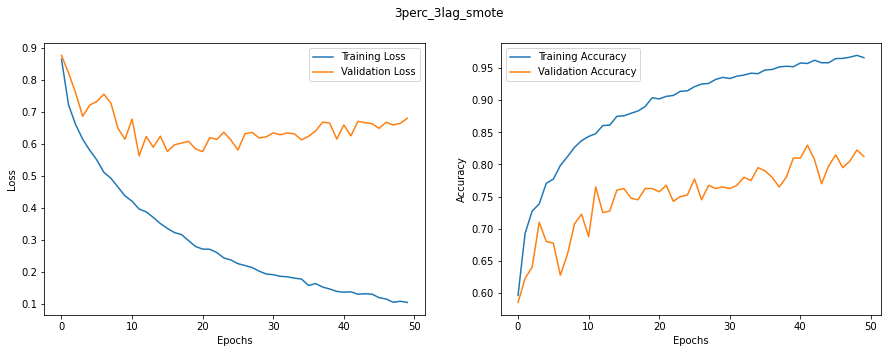

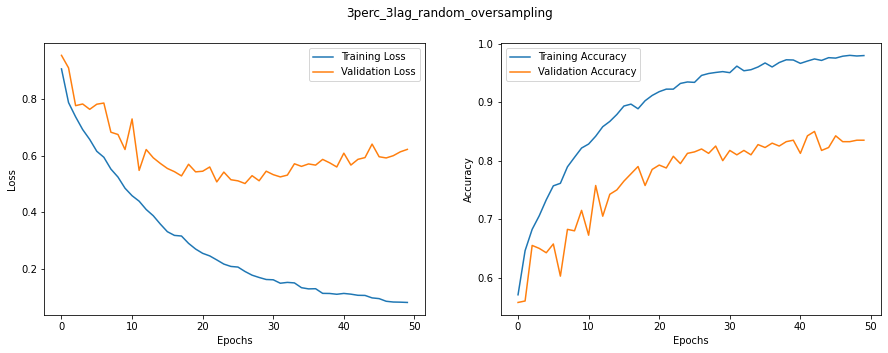

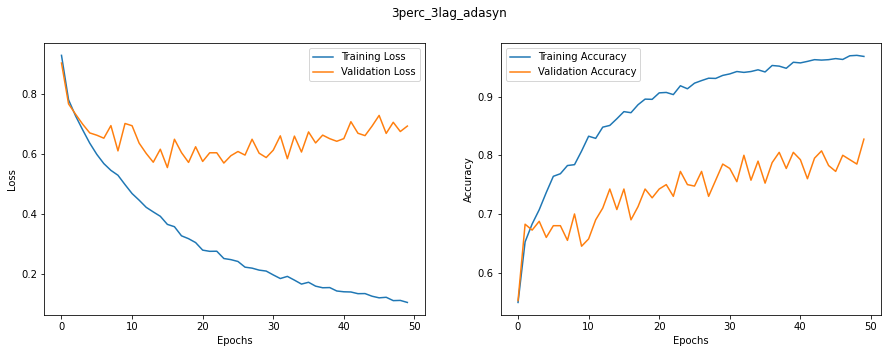

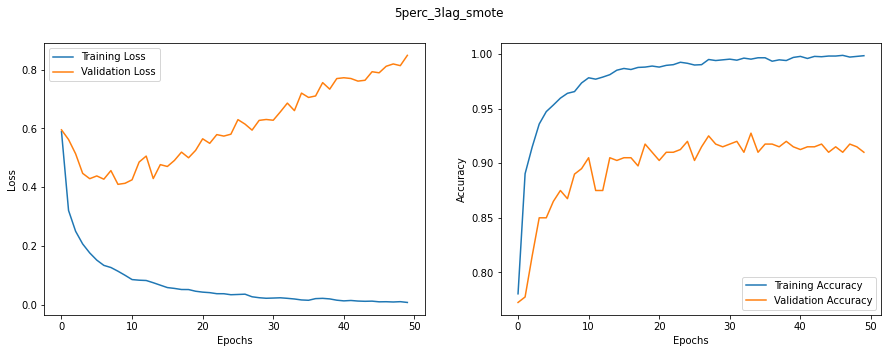

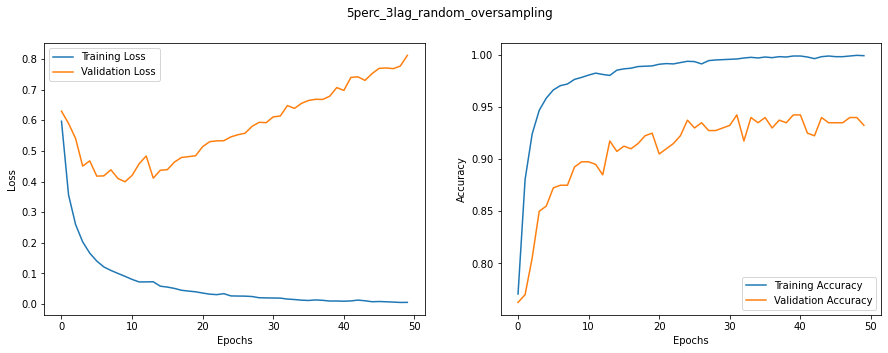

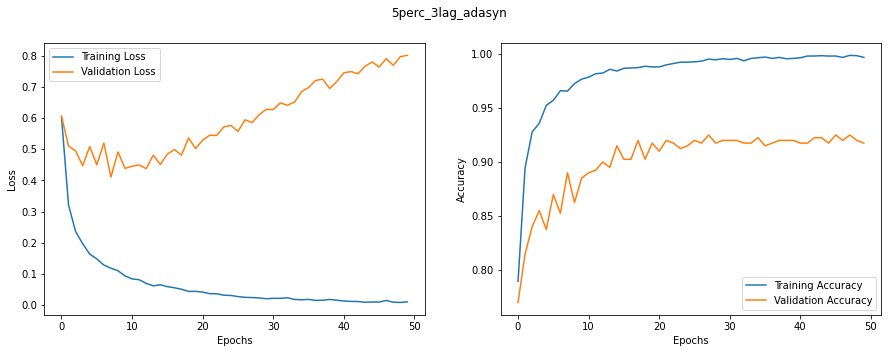

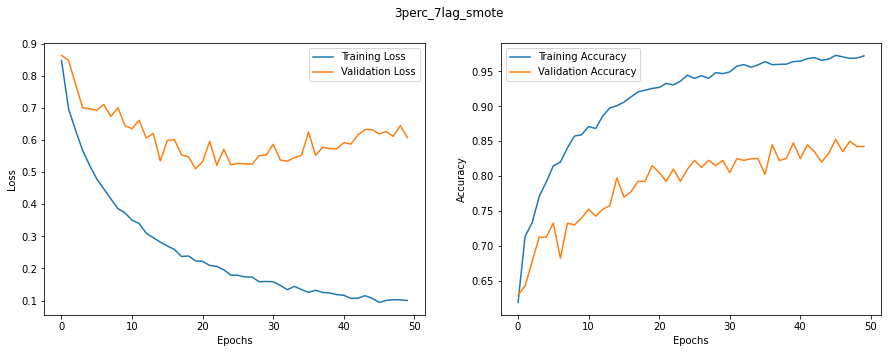

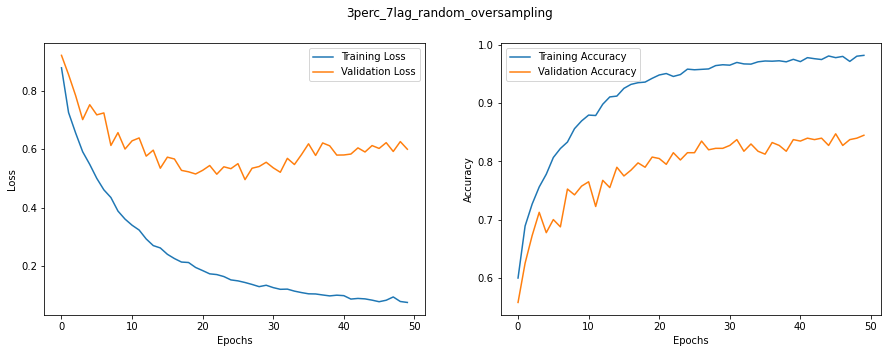

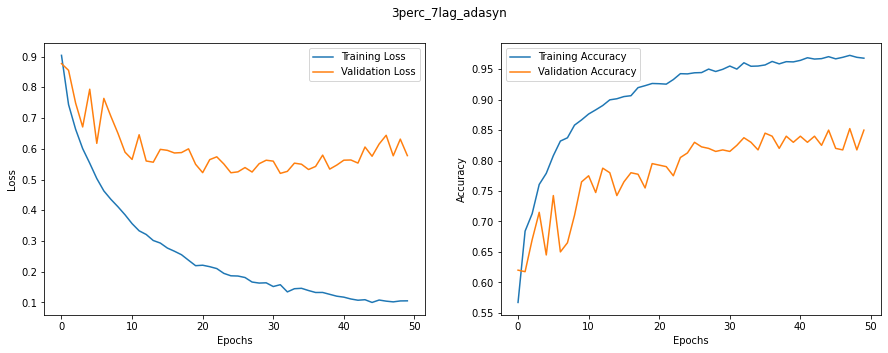

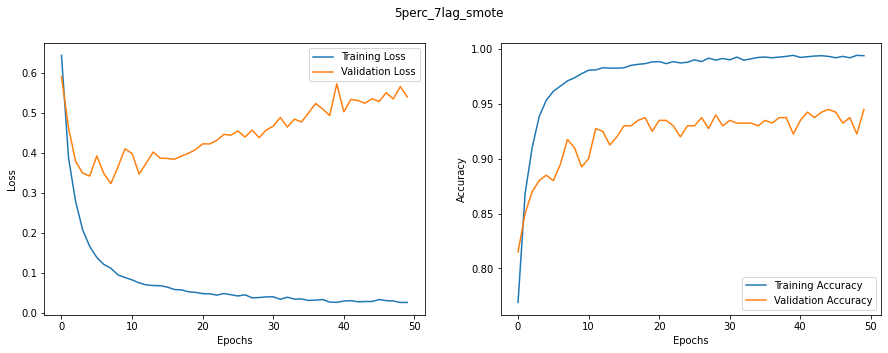

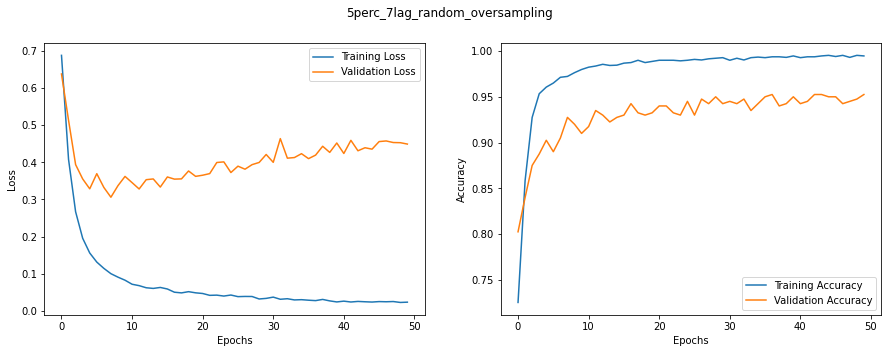

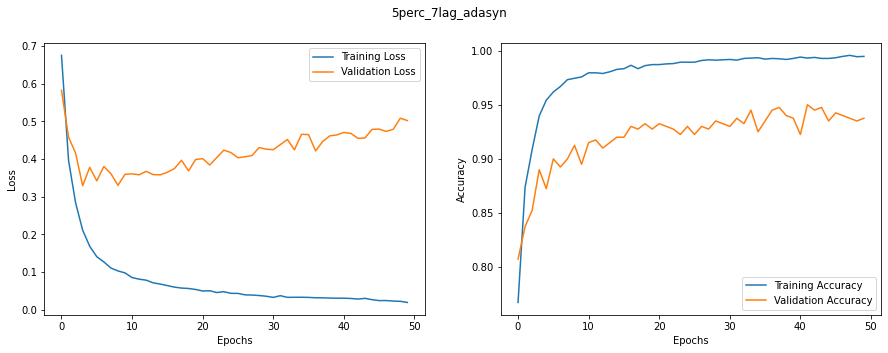

In [14]:
for (data_name, data) in data_dict.items():
    print(f'\n###### {data_name} ######')
    X_train, X_test, y_train, y_test = data[0], data[1], data[2], data[3]
    X_train, X_valid, X_test, y_train, y_valid, y_test = shuffle_numpy_encode(X_train, X_test, y_train, y_test)

    # oversampling
    sm = smote(X_train, y_train)
    ro = random_oversampler(X_train, y_train)
    ada = adasyn(X_train, y_train)
    oversampling_dict = {
        'smote': sm,
        'random_oversampling': ro,
        'adasyn': ada
    }

    for (oversampling_name, data) in oversampling_dict.items():
        print(f'------ {oversampling_name} ------')
        X_train = data[0]
        y_train = data[1]

        # create model
        model = create_model(learning_rate, X_train)
        # Train the model on the normalized training set.
        hist = train_model(model, X_train, y_train, epochs, (X_valid, y_valid), batch_size)
        # Plot a graph of the metric vs. epochs.
        plot_curve(hist, data_name+'_'+oversampling_name)

        # Evaluate on Test & Save results
        predict_x=model.predict(X_test) 
        predictions=np.argmax(predict_x,axis=1)
        model_f1_score = sklearn.metrics.f1_score(y_test,predictions, average='weighted')
        results.loc[data_name+ '_' + oversampling_name] = list(model.evaluate(X_test, y_test)) + [model_f1_score, set(predictions)]
        print(f'f1: {model_f1_score}')
        print(f'predictions: {set(predictions)}\n')

In [15]:
results.sort_values(['f1'], ascending=False)

,loss,accuracy,f1,Predictions
5perc_3lag_smote,11.144374,0.815476,0.732592,{0}
5perc_3lag_random_oversampling,10.950807,0.815476,0.732592,{0}
5perc_3lag_adasyn,12.375539,0.815476,0.732592,{0}
5perc_7lag_smote,9.969807,0.815476,0.732592,{0}
5perc_7lag_random_oversampling,7.615247,0.815476,0.732592,{0}
5perc_7lag_adasyn,8.332631,0.815476,0.732592,{0}
3perc_3lag_random_oversampling,4.889471,0.494048,0.377391,"{0, 1, 2}"
3perc_3lag_smote,5.607033,0.494048,0.372993,"{0, 1, 2}"
3perc_3lag_adasyn,7.003869,0.517857,0.368965,"{0, 1}"
3perc_7lag_random_oversampling,6.528511,0.505952,0.365506,"{0, 1}"


## Tuning

### Dataset
3 percent, 3 day lag, SMOTE

In [16]:
X_train, X_test, y_train, y_test = X_train_df_3perc_3lag, X_test_df_3perc_3lag, y_train_df_3perc_3lag, y_test_df_3perc_3lag
X_train, X_valid, X_test, y_train, y_valid, y_test = shuffle_numpy_encode(X_train, X_test, y_train, y_test)

# Doing Cross Validation
X_train_total = np.vstack([X_train, X_valid])
y_train_total = np.hstack([y_train, y_valid])

# oversampling
sm = smote(X_train, y_train)
X_train = sm[0]
y_train = sm[1]

### Tune

In [17]:
#optimisation
from bayes_opt import BayesianOptimization

# model building
import keras
from keras import layers
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten, Embedding, SimpleRNN, concatenate, Lambda
from keras.layers import LeakyReLU
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import metrics
from keras.losses import BinaryCrossentropy
from keras.wrappers.scikit_learn import KerasClassifier

from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, f1_score


def tuner(C, batch_size, neurons1, neurons2, neurons3, optimizer, dropout_rate, learning_rate, epochs, layers1, layers2):

    C = round(C, 3)
    optimizerL = ['SGD', 'Adam', 'RMSprop']
    optimizerD= {'Adam':tf.keras.optimizers.Adam(learning_rate=learning_rate), 'SGD':tf.keras.optimizers.SGD(learning_rate=learning_rate),
                  'RMSprop':tf.keras.optimizers.RMSprop(learning_rate=learning_rate)}
    optimizer = optimizerD[optimizerL[round(optimizer)]]
    neurons1 = round(neurons1)
    neurons2 = round(neurons2)
    neurons3 = round(neurons3)
    batch_size = round(batch_size)
    epochs = round(epochs)
    layers1 = round(layers1)
    layers2 = round(layers2)

    def create_model():
      tuned_model = tf.keras.models.Sequential()
      tuned_model.add(tf.keras.layers.Dense(input_shape=(X_train_total.shape[1],), units=neurons1, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(C)))

      for i in range(layers1): #varying first set of hidden layers
        tuned_model.add(Dense(neurons2, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(C)))

      tuned_model.add(Dropout(dropout_rate, seed=42))

      for i in range(layers2): #varying second set of hidden layers
          tuned_model.add(Dense(neurons3, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(C)))

      # output layer
      tuned_model.add(tf.keras.layers.Dense(units=3, activation='softmax'))    
      
      tuned_model.compile(loss="sparse_categorical_crossentropy", optimizer = optimizer, metrics=['accuracy'])

      return tuned_model    

    es = EarlyStopping(monitor="loss", patience=3)
    mc = ModelCheckpoint('Best_tuned_NN.h5', monitor='val_loss',mode='min',verbose=2, save_best_only=True)

    tune_rnn = KerasClassifier(build_fn=create_model, epochs=epochs, batch_size=batch_size, verbose=0) 
    score = cross_val_score(tune_rnn, X_train_total, y_train_total, fit_params={'callbacks':[es]}, error_score='raise', scoring=make_scorer(f1_score, average='weighted', labels=[0,1,2])).mean() #5 fold cross validation default
    return score


In [18]:
params ={
    'neurons1': (100, 500),
    'neurons2': (100, 500),
    'neurons3': (100, 500),
    'C': (0,1),
    'optimizer':(0,2),
    'learning_rate':(0.001, 0.01),
    'batch_size':(100, 1000),
    'epochs':(20, 100),
    'layers1':(1,3),
    'layers2':(0,3),
    'dropout_rate':(0,0.3)
}

In [19]:
# Run Bayesian Optimization
tune_results = BayesianOptimization(tuner, params, random_state=42)
# init points is the number of random parameter combinations to try default value is 5
# n_iter is the number of parameter combinations to try after initial random trials are completed. Default value is 25
tune_results.maximize(init_points=25, n_iter=50) 

|   iter    |  target   |     C     | batch_... | dropou... |  epochs   |  layers1  |  layers2  | learni... | neurons1  | neurons2  | neurons3  | optimizer |
-------------------------------------------------------------------------------------------------------------------------------------------------------------
| 1         | 0.7621    | 0.3745    | 955.6     | 0.2196    | 67.89     | 1.312     | 0.468     | 0.001523  | 446.5     | 340.4     | 383.2     | 0.04117   |
| 2         | 0.7621    | 0.9699    | 849.2     | 0.0637    | 34.55     | 1.367     | 0.9127    | 0.005723  | 272.8     | 216.5     | 344.7     | 0.279     |
| 3         | 0.7621    | 0.2921    | 429.7     | 0.1368    | 82.81     | 1.399     | 1.543     | 0.006332  | 118.6     | 343.0     | 168.2     | 0.1301    |
| 4         | 0.7621    | 0.9489    | 969.1     | 0.2425    | 44.37     | 1.195     | 2.053     | 0.004961  | 148.8     | 298.1     | 113.8     | 1.819     |
| 5         | 0.7621    | 0.2588    | 696.3     | 0.

### Best Model

In [20]:
best_params = tune_results.max["params"]
best_params

{'C': 0.0065989252860536585,
 'batch_size': 944.6049511830478,
 'dropout_rate': 0.2608031671036367,
 'epochs': 52.50187175256001,
 'layers1': 1.025700675780025,
 'layers2': 0.5568648542924697,
 'learning_rate': 0.0019094757633709306,
 'neurons1': 424.82783722167625,
 'neurons2': 121.90572919689279,
 'neurons3': 418.46704394556923,
 'optimizer': 0.5202571600918224}

In [21]:
optimizerL = ['Adam', 'SGD', 'RMSprop']
optimizerD= {'Adam':tf.keras.optimizers.Adam(learning_rate=round(best_params['learning_rate'],3)), 'SGD':tf.keras.optimizers.SGD(learning_rate=round(best_params['learning_rate'],3)),
              'RMSprop':tf.keras.optimizers.RMSprop(learning_rate=round(best_params['learning_rate'],3))}

In [22]:
tuned_model = tf.keras.models.Sequential()
tuned_model.add(tf.keras.layers.Dense(input_shape=(X_train.shape[1],), units=round(best_params['neurons1']), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(round(best_params['C'],3))))

for i in range(round(best_params['layers1'])): #varying first set of hidden layers
    tuned_model.add(Dense(round(best_params['neurons2']), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(round(best_params['C'], 3))))

tuned_model.add(Dropout(round(best_params['dropout_rate'],1), seed=42))

for i in range(round(best_params['layers2'])): #varying second set of hidden layers
    tuned_model.add(Dense(round(best_params['neurons3']), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(round(best_params['C'], 3))))

# output layer
tuned_model.add(tf.keras.layers.Dense(units=3, activation='softmax'))    

tuned_model.compile(loss="sparse_categorical_crossentropy", optimizer = optimizerD[optimizerL[round(best_params['optimizer'])]], metrics=['accuracy'])

tuned_history = tuned_model.fit(X_train, y_train, epochs=400, validation_data=(X_valid, y_valid))
tuned_model.summary()

Epoch 1/400
87/87 [==============================] - 1s 3ms/step - loss: 3.8895 - accuracy: 0.3477 - val_loss: 3.9313 - val_accuracy: 0.1625
Epoch 2/400
87/87 [==============================] - 0s 1ms/step - loss: 3.8617 - accuracy: 0.4105 - val_loss: 3.9036 - val_accuracy: 0.2350
Epoch 3/400
87/87 [==============================] - 0s 1ms/step - loss: 3.8372 - accuracy: 0.4804 - val_loss: 3.8782 - val_accuracy: 0.2975
Epoch 4/400
87/87 [==============================] - 0s 1ms/step - loss: 3.8118 - accuracy: 0.5308 - val_loss: 3.8544 - val_accuracy: 0.3400
Epoch 5/400
87/87 [==============================] - 0s 1ms/step - loss: 3.7864 - accuracy: 0.5481 - val_loss: 3.8316 - val_accuracy: 0.3675
Epoch 6/400
87/87 [==============================] - 0s 1ms/step - loss: 3.7619 - accuracy: 0.5733 - val_loss: 3.8100 - val_accuracy: 0.3925
Epoch 7/400
87/87 [==============================] - 0s 1ms/step - loss: 3.7357 - accuracy: 0.5737 - val_loss: 3.7881 - val_accuracy: 0.4100
Epoch 8/400
8

6/6 [==============================] - 0s 1ms/step - loss: 2.4157 - accuracy: 0.5357
f1: 0.4136146599561235
predictions: {0, 1, 2}


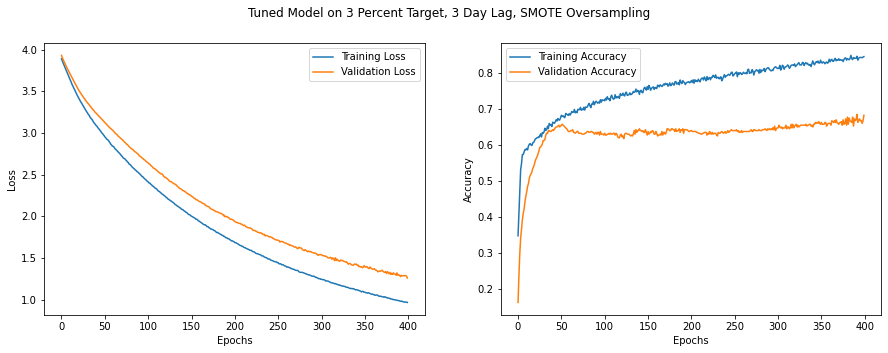

In [23]:
# Plot a graph of the metric vs. epochs.
plot_curve(tuned_history, 'Tuned Model on 3 Percent Target, 3 Day Lag, SMOTE Oversampling')

# Evaluate on Test & Save results
predict_x=tuned_model.predict(X_test) 
predictions=np.argmax(predict_x,axis=1)
model_f1_score = sklearn.metrics.f1_score(y_test,predictions, average='weighted')
results.loc['tuned_3perc_3lag_smote'] = list(tuned_model.evaluate(X_test, y_test)) + [model_f1_score, set(predictions)]

print(f'f1: {model_f1_score}')
print(f'predictions: {set(predictions)}')

In [24]:
results.sort_values(['f1'], ascending=False)

,loss,accuracy,f1,Predictions
5perc_3lag_smote,11.144374,0.815476,0.732592,{0}
5perc_3lag_random_oversampling,10.950807,0.815476,0.732592,{0}
5perc_3lag_adasyn,12.375539,0.815476,0.732592,{0}
5perc_7lag_smote,9.969807,0.815476,0.732592,{0}
5perc_7lag_random_oversampling,7.615247,0.815476,0.732592,{0}
5perc_7lag_adasyn,8.332631,0.815476,0.732592,{0}
tuned_3perc_3lag_smote,2.415713,0.535714,0.413615,"{0, 1, 2}"
3perc_3lag_random_oversampling,4.889471,0.494048,0.377391,"{0, 1, 2}"
3perc_3lag_smote,5.607033,0.494048,0.372993,"{0, 1, 2}"
3perc_3lag_adasyn,7.003869,0.517857,0.368965,"{0, 1}"


## Business Metrics

In [25]:
import yfinance as yf

In [26]:
whole_df_x = pd.concat([X_train_df_3perc_3lag, X_test_df_3perc_3lag])
whole_df_x.shape

(1679, 11)

In [27]:
whole_df_x = whole_df_x.reset_index()
whole_df_x['year'] = whole_df_x['index'].apply(lambda x: x.year)

In [28]:
business_metric_results = pd.DataFrame(columns=['exp_strategy_annual_return', 'exp_benchmark_annual_return'])

for year in [2016, 2017, 2018, 2019, 2020, 2021, 2022]:
    year_data = whole_df_x[whole_df_x['year'] == year]
    year_data = year_data.set_index('index')
    year_data = year_data.drop(['year'], axis = 1)
    predict_x=tuned_model.predict(np.array(year_data)) 
    predictions=np.argmax(predict_x,axis=1)

    df_pred = pd.DataFrame({'prediction':predictions}, index=year_data.index)
    df_pred = df_pred.replace({2:1, 1:-1}) # convert classes to buy hold sell
    dates = df_pred.index

    if year == 2022:
        end_date = "2022-09-02"
    else:
        end_date = str(year+1) + "-01-01"
    df_prices = yf.download("^GSPC", start=dates[0], end=end_date)[['Adj Close']]

    # create positions column
    positions = []
    prev = 0
    for i in range(len(df_pred)):
        if df_pred.iloc[i]['prediction'] == 0:
            positions.append(prev)
        else:
            prev = df_pred.iloc[i]['prediction']
            positions.append(prev)

    df_business = pd.DataFrame()
    df_business['stock_daily_log_return'] = np.log(df_prices /df_prices.shift(1))['Adj Close']
    df_business['prediction'] = df_pred['prediction']
    df_business['position'] = positions
    df_business['benchmark'] = 1 # long and hold strategy
    df_business["strategy_Returns"] = df_business["stock_daily_log_return"] * df_business["position"].shift(1)
    df_business["benchmark_Returns"] = df_business["stock_daily_log_return"] * df_business["benchmark"].shift(1)

    # Annual Mean Returns or Expected returns
    expected_strategy_annual_return = np.exp(df_business['strategy_Returns'].mean() * 252) - 1 
    expected_benchmark_annual_return = np.exp(df_business['benchmark_Returns'].mean() * 252) - 1 
    business_metric_results.loc[year] = [expected_strategy_annual_return, expected_benchmark_annual_return]
    # print(f'Expected Annual Returns: Strategy: {round(expected_strategy_annual_return*100, 2)}%  |  Stock: {round(expected_benchmark_annual_return*100, 2)}%')

business_metric_results

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,exp_strategy_annual_return,exp_benchmark_annual_return
2016,-0.031690,0.112846
2017,-0.155157,0.185753
2018,-0.109072,-0.070634
2019,0.067259,0.288443
2020,0.623636,0.152929
2021,0.023475,0.289230
2022,-0.176823,-0.249185
